In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
from fastai import *
from fastai.tabular import * 
from fastai.callbacks import *

In [4]:
import scanpy as sc
import pandas as pd
import numpy as np

In [5]:
import matplotlib
import matplotlib.pyplot as plt

In [6]:
from tempo.models import Tempo

from tempo.modules.loss import ELBO
from tempo.modules.stochastic import ScaledBernoulliSL

from tempo.callbacks.beta_warmup_elbo import BetaWarmupELBO
from tempo.callbacks.metrics import LossAttrMetric

In [7]:
matplotlib.rcParams['figure.figsize'] = [x * 1.2 for x in matplotlib.rcParams['figure.figsize']]

In [8]:
import torch

torch.cuda.set_device(0)

In [9]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

## Prepare data

In [10]:
adata = sc.read('total_counts.h5ad')
adata.X = (adata.raw[:, adata.var_names].X > 0).astype(int)
adata

AnnData object with n_obs × n_vars = 35485 × 25000 
    obs: 'exp_id', 'timepoint', 'n_genes', 'n_peaks_by_counts', 'log1p_n_peaks_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_peaks', 'pct_counts_in_top_100_peaks', 'pct_counts_in_top_200_peaks', 'pct_counts_in_top_500_peaks', 'n_counts', 'X_pca_0'
    var: 'chr', 'start', 'end', 'length', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'count_variance'
    uns: 'exp_id_colors', 'neighbors', 'pca', 'timepoint_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [11]:
# make sure timepoints are in the right oder
adata.obs['timepoint'] = adata.obs['timepoint'].cat.set_categories(['2to4', '6to8', '10to12'])

# extract counts
var_names = adata.var_names
obs_names = adata.obs_names
df = pd.DataFrame(
    data=adata.X.todense(), 
    index=obs_names, 
    columns = var_names)

# batch and timepoint ids
df['batch'] = adata.obs['exp_id'].cat.codes
df['window'] = adata.obs['timepoint'].cat.codes

# compute size factor priors
df['cell_log_counts'] = np.log(df.sum(1))

l_locs = df[['cell_log_counts', 'batch']].groupby('batch').apply(np.mean)['cell_log_counts'].to_numpy()
l_scales = df[['cell_log_counts', 'batch']].groupby('batch').apply(np.std)['cell_log_counts'].to_numpy() 

l_locs = l_locs.reshape(-1, 1)
l_scales = l_scales.reshape(-1, 1)

df.drop('cell_log_counts', 1, inplace=True)

## Turn into fastai databunch

In [12]:
input_cols = df.columns.tolist()
output_cols = ['window'] # actually no output_cols are needed

In [13]:
src = FloatList.from_df(df, cols=input_cols)
#src = src.split_by_rand_pct(valid_pct=0.1)
src = src.split_none()
src = src.label_from_df(cols=output_cols, label_cls=FloatList)
src = src.databunch(bs=300)

## Create model and learner

In [14]:
model = Tempo(
    dim_x=adata.shape[1],
    dim_z=8,
    n_windows=3,
    l_locs=l_locs,
    l_scales=l_scales,
    d_hidden_encoder_z=[256, 128],
    d_hidden_encoder_l=[256],
    d_hidden_decoder_x=[64, 128],
    d_hidden_decoder_t=None,
    likelihood_layer=ScaledBernoulliSL,
    learn_time_variance=False,
    mc_samples=5)

In [15]:
beta_update = 1/25
learn = Learner(
    data=src, 
    model=model,
    loss_func=ELBO(model, beta=beta_update),
    callback_fns=[
        #partial(LossAttrMetric, attr='kl_div'), 
        partial(BetaWarmupELBO, beta_update=beta_update)
    ])

## Train model

In [16]:
learn.fit_one_cycle(5, max_lr=1e-4)

In [17]:
learn.fit_one_cycle(25, max_lr=1e-2)

## Compute embedding and estimate time ordering for all cells

In [18]:
model = model.eval().cpu()

In [19]:
x, b, w = model.split_observed(torch.Tensor(df[input_cols].to_numpy()))

z_dist = model.posterior_z(x, b)
l_dist = model.posterior_l(x, b)

l = l_dist.sample()
z = z_dist.sample()

In [20]:
adata.obsm['X_vae'] = z.detach().numpy()
adata.obs['size_vae'] = l_dist.mean.detach().numpy()
adata.obs['time_vae'] = model.likelihood(z, l, b).base_distributions[1].mean.detach().numpy()
# normalize to [0, 1]
adata.obs['time_vae'] = (adata.obs['time_vae'] - adata.obs['time_vae'].min()) / (adata.obs['time_vae'].max() - adata.obs['time_vae'].min())
adata.layers['vae_peak_activities'] = model.compute_activities(z, b).detach().numpy()

In [21]:
adata.write('total_counts_vae.h5ad')

## Visualize

In [22]:
sc.pp.neighbors(adata, n_pcs=model.dim_z, use_rep='X_vae')
sc.tl.umap(adata, min_dist=.1)
sc.tl.leiden(adata, resolution=1, key_added='leiden_vae')

/home/heinent/miniconda3/envs/pytorch/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../miniconda3/envs/pytorch/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/home/heinent/miniconda3/envs/pytorch/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../minicond

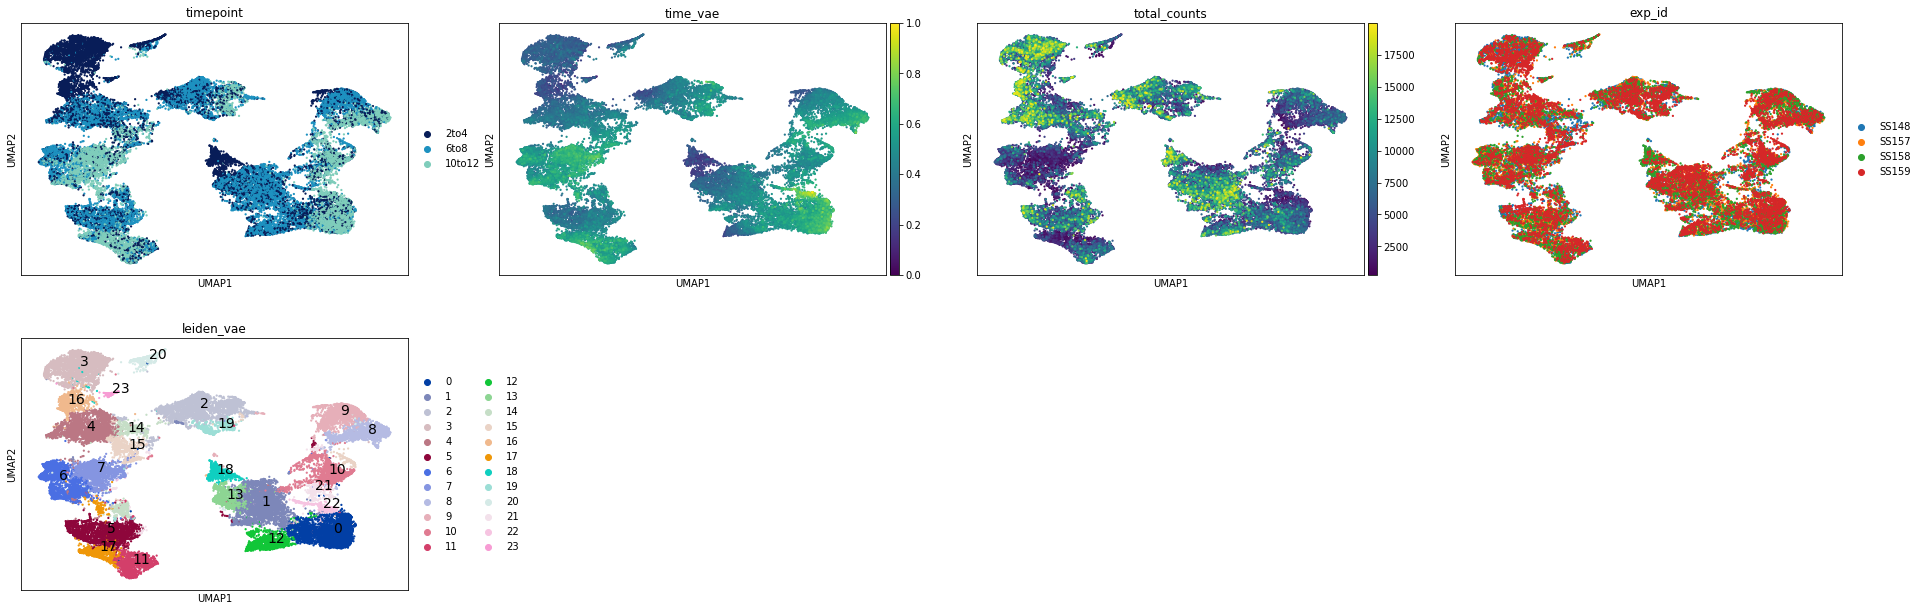

In [23]:
ax = sc.pl.umap(adata, color=['timepoint', 'time_vae', 'total_counts', 'exp_id', 'leiden_vae'], s=20, show=False)
ax = ax[4]
df_cluster_means = pd.DataFrame(adata.obsm['X_umap'], index=adata.obs.index)
df_cluster_means['leiden_vae'] = adata.obs['leiden_vae']
df_cluster_means = df_cluster_means.groupby('leiden_vae').median()

for i in df_cluster_means.index:
    i = int(i)
    ax.text(df_cluster_means.iloc[i, 0], df_cluster_means.iloc[i, 1], i, {'fontsize': 14})

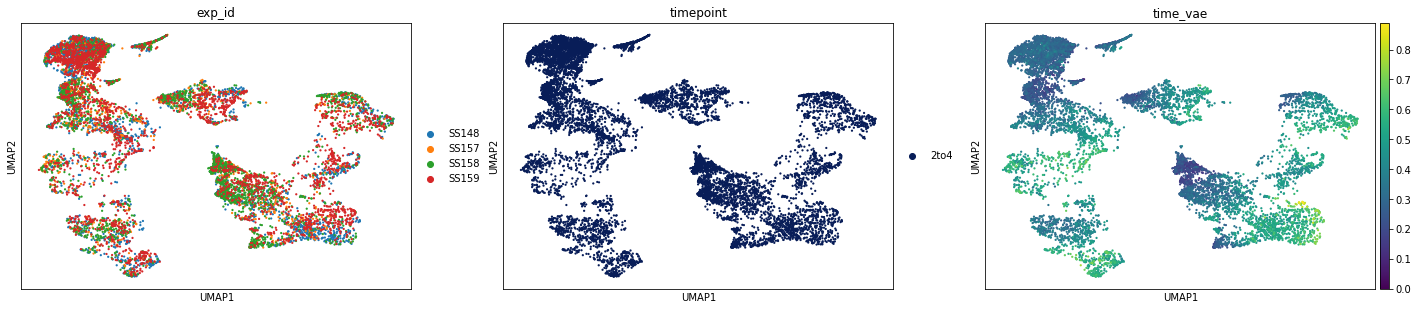

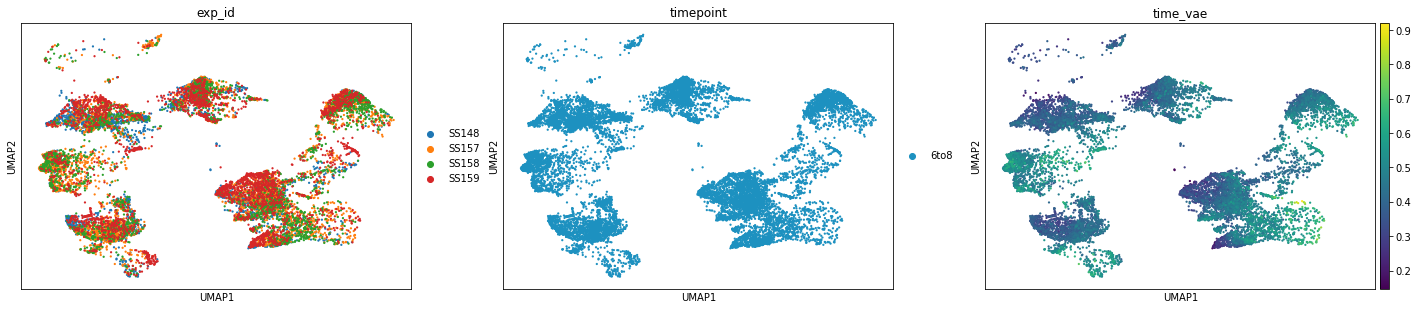

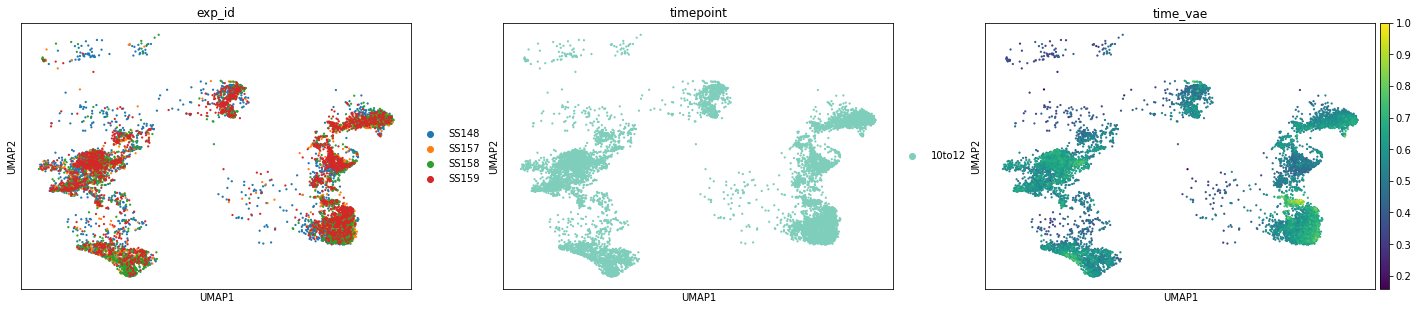

In [24]:
for time in adata.obs['timepoint'].cat.categories:
    sc.pl.umap(adata[adata.obs['timepoint'] == time], color=['exp_id', 'timepoint', 'time_vae'], size=20)

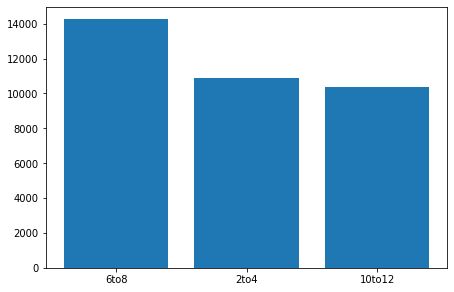

In [25]:
plt.bar(x=adata.obs['timepoint'].value_counts().index, height=adata.obs['timepoint'].value_counts());

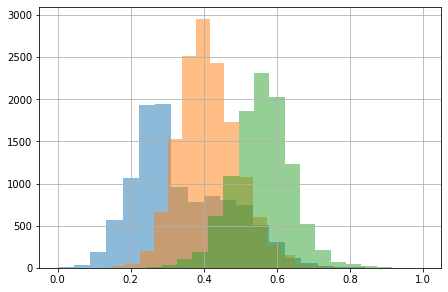

In [26]:
adata.obs.groupby('timepoint')['time_vae'].hist(alpha=.5, bins=20);

In [27]:
from matplotlib import animation, rc
from IPython.display import HTML

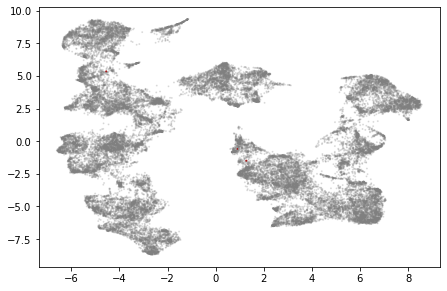

In [28]:
numframes = 20

color_data = np.zeros((numframes, adata.shape[0]))
for i in range(numframes):
    color_data[i, :] = (adata.obs['time_vae'] > i*(1/numframes)) & (adata.obs['time_vae'] < ((i+1)/numframes))

fig = plt.figure()
scat = plt.scatter(adata.obsm['X_umap'][:, 0], adata.obsm['X_umap'][:, 1], s=1)

def update_plot(i, data, scat):
    ids = data[i] > 0
    colors = np.zeros((data[i].size, 4))
    colors[ids, :] = np.asarray([0.7, 0, 0, 1])
    colors[~ids, :] = np.asarray([0.5, 0.5, 0.5, .2])
    #scat.set_array(data[i])
    scat.set_color(colors)
    return scat,

anim = animation.FuncAnimation(
    fig, update_plot, frames=range(numframes), fargs=(color_data, scat))

HTML(anim.to_jshtml())

In [29]:
anim.save('animation.gif', writer='imagemagick', fps=2)